In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_dataloader, TextDataset
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "Finetune"
dataset_name = "AG_news"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Loading AG news datase

In [4]:
ag_news_dataset = load_dataset("ag_news")

## Number of classes / Classes distribution

In [5]:
num_classes = len(ag_news_dataset['train']\
    .features['label']\
    .names)

classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

num_classes

4

In [7]:
np.unique(ag_news_dataset['train']['label'],
          return_counts= True)

(array([0, 1, 2, 3]), array([30000, 30000, 30000, 30000]))

## Finetuning in the entire data

In [8]:
data_size = len(ag_news_dataset['train'])
data_size

120000

In [40]:
train_text = ag_news_dataset['train']['text'][0:data_size*3//5]
train_labels = ag_news_dataset['train']['label'][0:data_size*3//5]

val_text = ag_news_dataset['train']['text'][data_size*3//5:]
val_labels = ag_news_dataset['train']['label'][data_size*3//5:]

### BERT

In [12]:
bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = num_classes)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
train_dataloader = get_dataloader(
    train_text,
    train_labels,
    tokenizer,
    n_shots = 200,
    num_classes= num_classes,
    batch_size = 8
)

800

In [42]:
val_dataloader = get_dataloader(
    val_text,
    val_labels,
    tokenizer,
    n_shots = 100,
    num_classes=num_classes
)

In [45]:
np.unique(
    val_dataloader.dataset[0:400]['labels'],
    return_counts= True

)

(array([0., 1., 2., 3.], dtype=float32), array([100, 100, 100, 100]))

In [15]:
bert = AutoModelForSequenceClassification\
    .from_pretrained("bert-base-uncased", num_labels = num_classes)\
    .to(device)

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)

history = trainer.compile(
    train_dataloader,
    val_dataloader,
    100,
    500
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [00:06<00:00, 76.16it/s] 


In [16]:
history = trainer.history

Text(0, 0.5, 'F1 score')

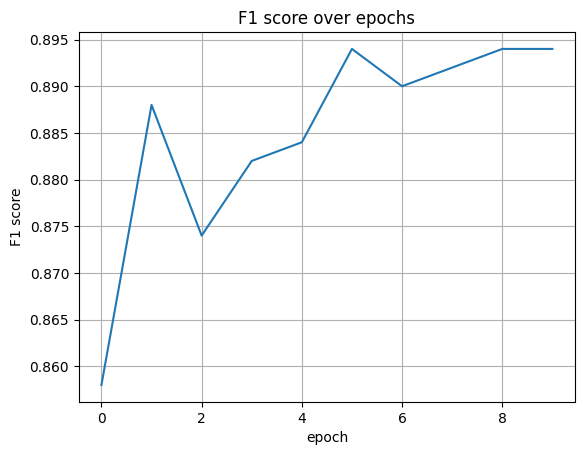

In [38]:
plt.plot([x.item() for x in history['val_f1']])
plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix AG-News 100 shots')

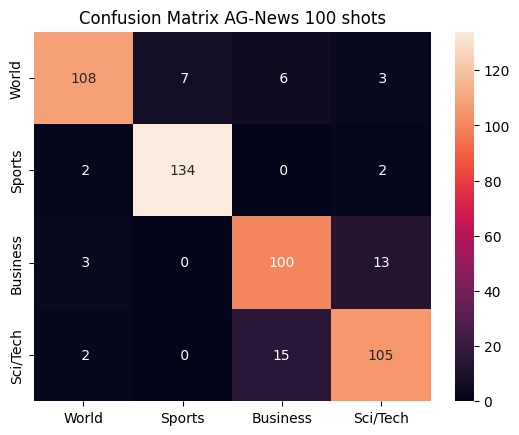

In [33]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Confusion Matrix AG-News 100 shots")

In [34]:
trainer.best_model.push_to_hub("peulsilva/ag_news_finetune_100_shots")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/ag_news_finetune_100_shots/commit/52acf0dd59b65fb460e89c5b7ca89ba7ce1deb57', commit_message='Upload BertForSequenceClassification', commit_description='', oid='52acf0dd59b65fb460e89c5b7ca89ba7ce1deb57', pr_url=None, pr_revision=None, pr_num=None)

## Performance decay 

In [77]:
histories = {}

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

for i in range(6):

    bert = AutoModelForSequenceClassification\
        .from_pretrained("bert-base-uncased", num_labels = num_classes)\
        .to(device)

    trainer = SequenceClassificationTrainer(
        bert,
        num_classes
    )
    n_shots = 100//2**i
    
    train_dataloader = get_dataloader(
        train_text,
        train_labels,
        tokenizer,
        n_shots= n_shots,
        num_classes= num_classes,
        shuffle = True,
        worker_init_fn=seed_worker,
        generator=g
    )

    val_dataloader = get_dataloader(
        val_text,
        val_labels,
        tokenizer,
        n_shots = 250,
        num_classes=num_classes
    )

    history = trainer.compile(
        train_dataloader,
        val_dataloader,
        n_epochs=5
    )

    histories[100//2**i] = history

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 400/400 [00:21<00:00, 18.67it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 200/200 [00:10<00:00, 18.32it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/

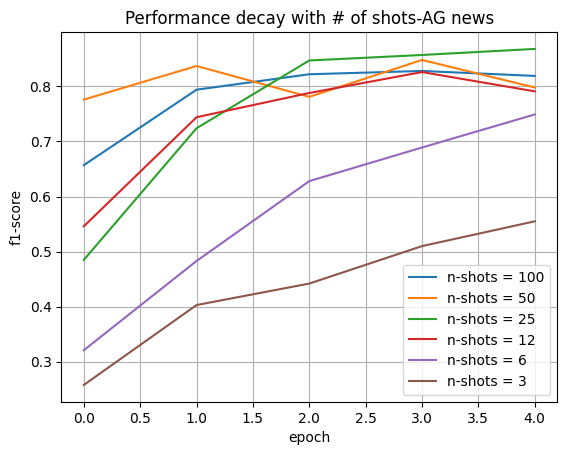

In [81]:
results = {}
for k, v in histories.items():
    plt.plot(v['val_f1'],
             label = f"n-shots = {k}")
    
plt.title("Performance decay with # of shots-AG news")
    
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.show()

In [84]:
for k,v in histories.items():
    print(f"n-shots: {k} - f1 score : {np.max(v['val_f1'])}")

n-shots: 100 - f1 score : 0.828000009059906
n-shots: 50 - f1 score : 0.8479999899864197
n-shots: 25 - f1 score : 0.8679999709129333
n-shots: 12 - f1 score : 0.8259999752044678
n-shots: 6 - f1 score : 0.7490000128746033
n-shots: 3 - f1 score : 0.5550000071525574
